In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics

from sklearn.model_selection import train_test_split

%matplotlib inline

#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
columns = ['x-axis', 'y-axis','z-axis','xg-axis', 'yg-axis','zg-axis','activity']
df=pd.read_csv("Act1_noise2.csv",names=columns,skiprows=1)


In [3]:
df

,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,1
1,0.0934,-0.1225,0.7399,37.8049,-152.7439,-26.8902,1
2,0.1689,-0.0379,0.9245,45.0610,-147.9878,-25.7317,1
3,0.2049,0.0226,1.0523,53.5366,-134.3902,-27.1341,1
4,0.2417,0.0170,1.1290,53.2317,-117.6829,-25.9146,1
...,...,...,...,...,...,...,...
61202,-0.7471,-0.2786,0.5436,-7.0732,-9.2683,-17.9878,2
61203,-0.7456,-0.2745,0.5353,-2.3780,-6.2805,-14.5732,2
61204,-0.7316,-0.2733,0.5357,-2.9268,-6.5244,-11.5854,2
61205,-0.7307,-0.2755,0.5414,-2.6220,-7.9268,-9.7561,2


In [4]:
tf.__version__

'1.4.0'

In [5]:
df.shape

(61207, 7)

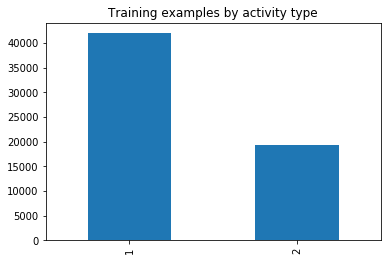

In [6]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [7]:
N_TIME_STEPS = 500
N_FEATURES = 6
step = 100
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
    ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
    zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    #print label
    segments.append([xs, ys, zs, xsg, ysg, zsg])
    labels.append(label)
    #print labels

In [8]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [9]:
reshaped_segments.shape

(608, 500, 6)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [11]:
X_train.shape

(486, 500, 6)

In [12]:
X_test.shape

(122, 500, 6)

In [13]:
#y_test

In [14]:
N_CLASSES = 2
N_HIDDEN_UNITS = 64

In [15]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden =tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [16]:
#tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [17]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [18]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [19]:
LEARNING_RATE = 0.00025
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [20]:
N_EPOCHS = 40
BATCH_SIZE = 128

In [21]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)
    #if i != 1 and i % 10 != 0:
        #continue

    print("epoch " + str(i) + ":  "+ "test accuracy:" + " " + str(acc_test) + " " + "loss:" + str(loss_test))
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

#print()
print("final results: accuracy:   " + str(acc_final) + "\t" +  "loss:  " +str(loss_final))

epoch 1:  test accuracy: 0.6803279 loss:1.4047714
epoch 2:  test accuracy: 0.6639344 loss:1.379606
epoch 3:  test accuracy: 0.72131145 loss:1.3356459
epoch 4:  test accuracy: 0.73770493 loss:1.3248844
epoch 5:  test accuracy: 0.72131145 loss:1.3200016
epoch 6:  test accuracy: 0.71311474 loss:1.3258638
epoch 7:  test accuracy: 0.72131145 loss:1.3193716
epoch 8:  test accuracy: 0.7295082 loss:1.3142917
epoch 9:  test accuracy: 0.73770493 loss:1.3157892
epoch 10:  test accuracy: 0.72131145 loss:1.3196415
epoch 11:  test accuracy: 0.71311474 loss:1.3158666
epoch 12:  test accuracy: 0.7295082 loss:1.3053786
epoch 13:  test accuracy: 0.72131145 loss:1.3007888
epoch 14:  test accuracy: 0.6967213 loss:1.2998278
epoch 15:  test accuracy: 0.704918 loss:1.2959158
epoch 16:  test accuracy: 0.71311474 loss:1.2896143
epoch 17:  test accuracy: 0.71311474 loss:1.2847815
epoch 18:  test accuracy: 0.72131145 loss:1.279408
epoch 19:  test accuracy: 0.7295082 loss:1.2725883
epoch 20:  test accuracy: 0.721

In [22]:
#predictions

In [23]:
pickle.dump(predictions, open("predictions_act1.p", "wb"))
pickle.dump(history, open("history_act1.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/activity_1.pbtxt')  
saver.save(sess, save_path = "./checkpoint/activity_1.ckpt")
sess.close()

In [24]:
history = pickle.load(open("history_act1.p", "rb"))
predictions = pickle.load(open("predictions_act1.p", "rb"))

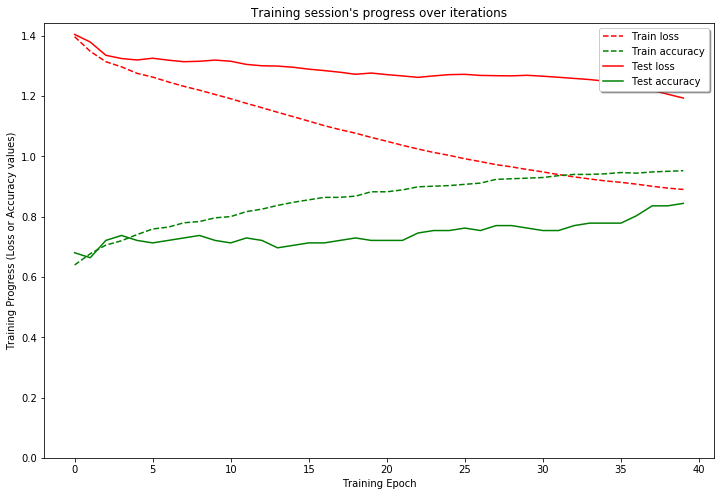

In [25]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [26]:
#activity
LABELS = [1,2]

In [27]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [28]:
#max_test = np.argmax(y_test, axis=1)
#ls = list(max_test)
#ls


In [29]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)

max_test1 = max_test.tolist()
print (max_test1)
print (len(max_test1))
max_predictions1 = max_predictions.tolist()
print(max_predictions1)
print(len(max_predictions1))

confusion_matrix(max_test1, max_predictions1)


[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
122
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]
122


array([[83,  8],
       [11, 20]])

In [30]:
def data_reshaping(df):
    #df['activity'].value_counts().plot(kind='bar', title='Testing examples by activity type');
    N_TIME_STEPS = 500
    N_FEATURES = 6
    step = 100
    segments = []
    test_labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        xs = df['x-axis'].values[i: i + N_TIME_STEPS]
        ys = df['y-axis'].values[i: i + N_TIME_STEPS]
        zs = df['z-axis'].values[i: i + N_TIME_STEPS]
        xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
        ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
        zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
        
        label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        segments.append([xs, ys, zs, xsg, ysg,zsg])
        test_labels.append(label)
    #print test_labels
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
    #test_labels = np.asarray(pd.get_dummies(test_labels), dtype = np.float32)
    #X_train, X_test, y_train, y_test = train_test_split(
        #reshaped_segments, test_labels, test_size=0.99, random_state=RANDOM_SEED)
    X_test = reshaped_segments
    y_test = test_labels
    
    #print test_labels
    return X_test, y_test
    

In [33]:
columns1=['ep','x-axis', 'y-axis' ,'z-axis' ,'xg-axis' ,'yg-axis' ,'zg-axis']
test = pd.read_csv('Sample10sub_act2.csv', header = None, names = columns1,skiprows=1)
test

,ep,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis
0,1.574147e+12,0.1182,-0.0387,0.0507,-2.3171,-2.6220,0.3659
1,1.574147e+12,0.1204,-0.0432,0.0462,-5.4878,-8.1707,-0.3049
2,1.574147e+12,0.1194,-0.0455,0.0406,-7.9878,-15.1220,-0.2439
3,1.574147e+12,0.1161,-0.0449,0.0385,-9.8780,-24.9390,0.2439
4,1.574147e+12,0.1133,-0.0428,0.0389,-12.1951,-36.5244,-0.8537
...,...,...,...,...,...,...,...
1352,1.574147e+12,0.0840,-0.0642,0.0568,-36.4634,26.3415,-30.4878
1353,1.574147e+12,0.0720,-0.0662,0.0507,-37.1341,25.3049,-38.6585
1354,1.574147e+12,0.0619,-0.0633,0.0438,-37.9878,16.8902,-45.1220
1355,1.574147e+12,0.0715,-0.0527,0.0441,-34.5732,12.5000,-51.0976


In [34]:
test['activity']=1

In [35]:
test

,ep,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,1.574147e+12,0.1182,-0.0387,0.0507,-2.3171,-2.6220,0.3659,1
1,1.574147e+12,0.1204,-0.0432,0.0462,-5.4878,-8.1707,-0.3049,1
2,1.574147e+12,0.1194,-0.0455,0.0406,-7.9878,-15.1220,-0.2439,1
3,1.574147e+12,0.1161,-0.0449,0.0385,-9.8780,-24.9390,0.2439,1
4,1.574147e+12,0.1133,-0.0428,0.0389,-12.1951,-36.5244,-0.8537,1
...,...,...,...,...,...,...,...,...
1352,1.574147e+12,0.0840,-0.0642,0.0568,-36.4634,26.3415,-30.4878,1
1353,1.574147e+12,0.0720,-0.0662,0.0507,-37.1341,25.3049,-38.6585,1
1354,1.574147e+12,0.0619,-0.0633,0.0438,-37.9878,16.8902,-45.1220,1
1355,1.574147e+12,0.0715,-0.0527,0.0441,-34.5732,12.5000,-51.0976,1


In [36]:
x_test1, y_test1 = data_reshaping(test)

In [37]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver = tf.train.import_meta_graph("./checkpoint/activity_1.ckpt.meta")
    saver.restore(sess,tf.train.latest_checkpoint("./checkpoint"))
    predictions1= sess.run(pred_softmax, feed_dict={X: x_test1})
    #predictions, acc_final, loss_final = sess.run([pred_softmax, a, feed_dict={X: X_test1, Y: y_test1})
    sess.close()

INFO:tensorflow:Restoring parameters from ./checkpoint/activity_1.ckpt


In [38]:
y_ls = list(y_test1)
print(len(y_ls))
print(y_ls)

9
[1, 1, 1, 1, 1, 1, 1, 1, 1]


In [39]:
max_predictions1 = np.argmax(predictions1, axis=1) + 1
print(len(list(max_predictions1)))
print((max_predictions1))

9
[1 1 2 1 1 2 1 1 1]


In [40]:

a=confusion_matrix(y_ls, max_predictions1)
print(a)
accuracy = ((a[0][0])*100)/(len(max_predictions1))
print(accuracy)

[[7 2]
 [0 0]]
77.77777777777777
